## **IMPORT LIBRARY**

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO

## **LOAD MODEL, GAMBAR, DAN PREDIKSI OBJEK**

In [21]:
img = cv2.imread("pesawat.jpg")

# Load model segmentasi YOLOv8
model = YOLO("yolov8s-seg.pt")  # ganti model jika kamu punya custom

# Ambil nama kelas dari model
yolo_classes = list(model.names.values())
num_classes = len(yolo_classes)

# Warna tiap kelas (pakai colormap matplotlib)
colormap = plt.cm.get_cmap("tab20", num_classes)
colors = [tuple(int(c * 255) for c in colormap(i)[:3]) for i in range(num_classes)]

conf = 0.3
results = model.predict(img, conf=conf)


0: 384x640 14 airplanes, 334.9ms
Speed: 3.6ms preprocess, 334.9ms inference, 21.5ms postprocess per image at shape (1, 3, 384, 640)


## **SEGMENTASI**

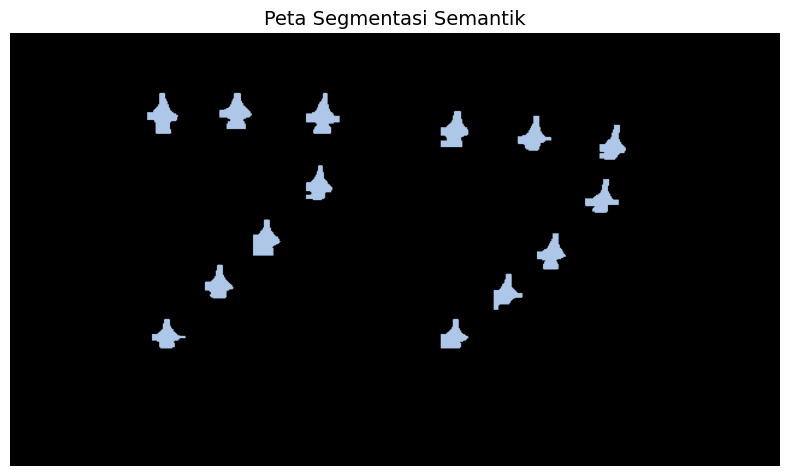

In [38]:
semantic_map = np.zeros(img.shape[:2], dtype=np.uint8)
semantic_rgb = np.zeros_like(img)
img_with_box = img.copy()

# Loop semua deteksi
if result.masks is not None:
    for seg, box, cls in zip(result.masks.data, result.boxes.xyxy, result.boxes.cls):
        class_id = int(cls)
        color = colors[class_id]

        # Resize mask
        mask = seg.cpu().numpy()
        mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
        mask_bin = (mask_resized > 0.5).astype(np.uint8)

        # Tambahkan ke semantic map
        semantic_map[mask_bin == 1] = class_id + 1
        semantic_rgb[mask_bin == 1] = color

        # Tambahkan bounding box dan label
        x1, y1, x2, y2 = box.int().cpu().numpy()
        label = f"{yolo_classes[class_id]}"
        cv2.rectangle(img_with_box, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_with_box, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, lineType=cv2.LINE_AA)

# Konversi BGR ke RGB untuk ditampilkan dengan matplotlib
img_with_box_rgb = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(semantic_rgb)
plt.title("Peta Segmentasi Semantik", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


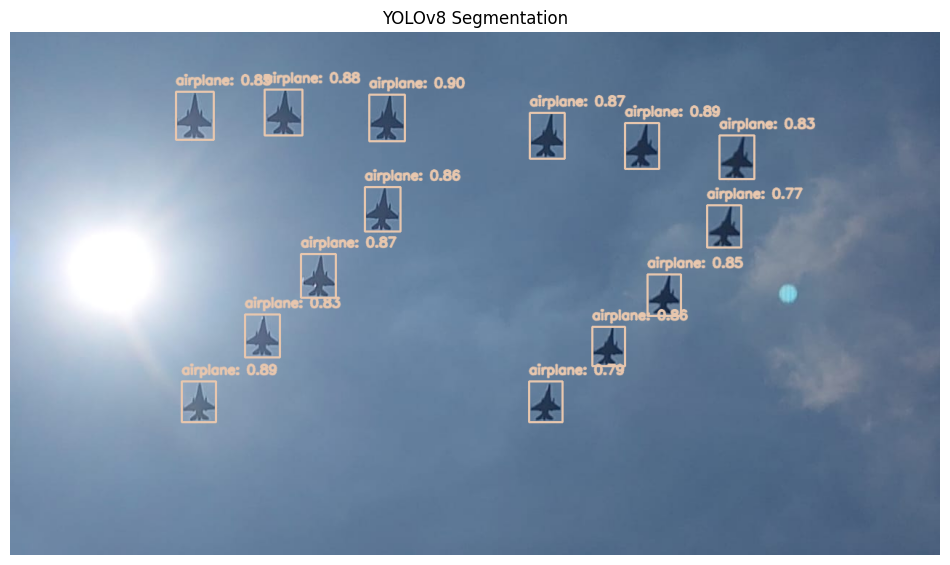

In [39]:
img_annotated = img.copy()

for result in results:
    if result.masks is None or result.boxes is None:
        continue

    for mask, box in zip(result.masks.xy, result.boxes):

        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        color = colors[classes_ids.index(class_id)]

        # koordinat bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Gambar bounding box saja
        cv2.rectangle(img_annotated, (x1, y1), (x2, y2), color, 2)  # Tebal garis 

        # Label teks
        label_text = f"{yolo_classes[class_id]}: {confidence:.2f}"
        cv2.putText(img_annotated, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 2, lineType=cv2.LINE_AA)

img_rgb = cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLOv8 Segmentation")
plt.show()
